In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_losses

In [ ]:
# Comment out, if you want tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Two Moons

In [4]:
benchmark_name = 'two_moons'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the two_moons model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer

In [5]:
amortizer = AmortizedPosteriorLikelihood(
    AmortizedPosterior(InvertibleNetwork(num_params=2, num_coupling_layers=5, coupling_design='interleaved', permutation='learnable')),
    AmortizedLikelihood(InvertibleNetwork(num_params=2, num_coupling_layers=5, coupling_design='interleaved', permutation='learnable'))
)

In [6]:
trainer = Trainer(
    amortizer=amortizer,
    generative_model=benchmark.generative_model,
    configurator=benchmark.configurator,
    checkpoint_path=f'checkpoints/{benchmark_name}',
    max_to_keep=1,
    memory=False   
)

INFO:root:Loaded loss history from checkpoints/two_moons/history_50.pkl.
INFO:root:Networks loaded from checkpoints/two_moons/ckpt-50
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training
Uncomment for training. Wall time with GPU: approx. 18min 22s

In [7]:
# EPOCHS = 50
# SIMULATION_BUDGET = 10000
# N_VAL = 300
# BATCH_SIZE = 32

# train_data = trainer.generative_model(SIMULATION_BUDGET)

In [8]:
# %%time
# h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

# Validation

## Loss Trajectories

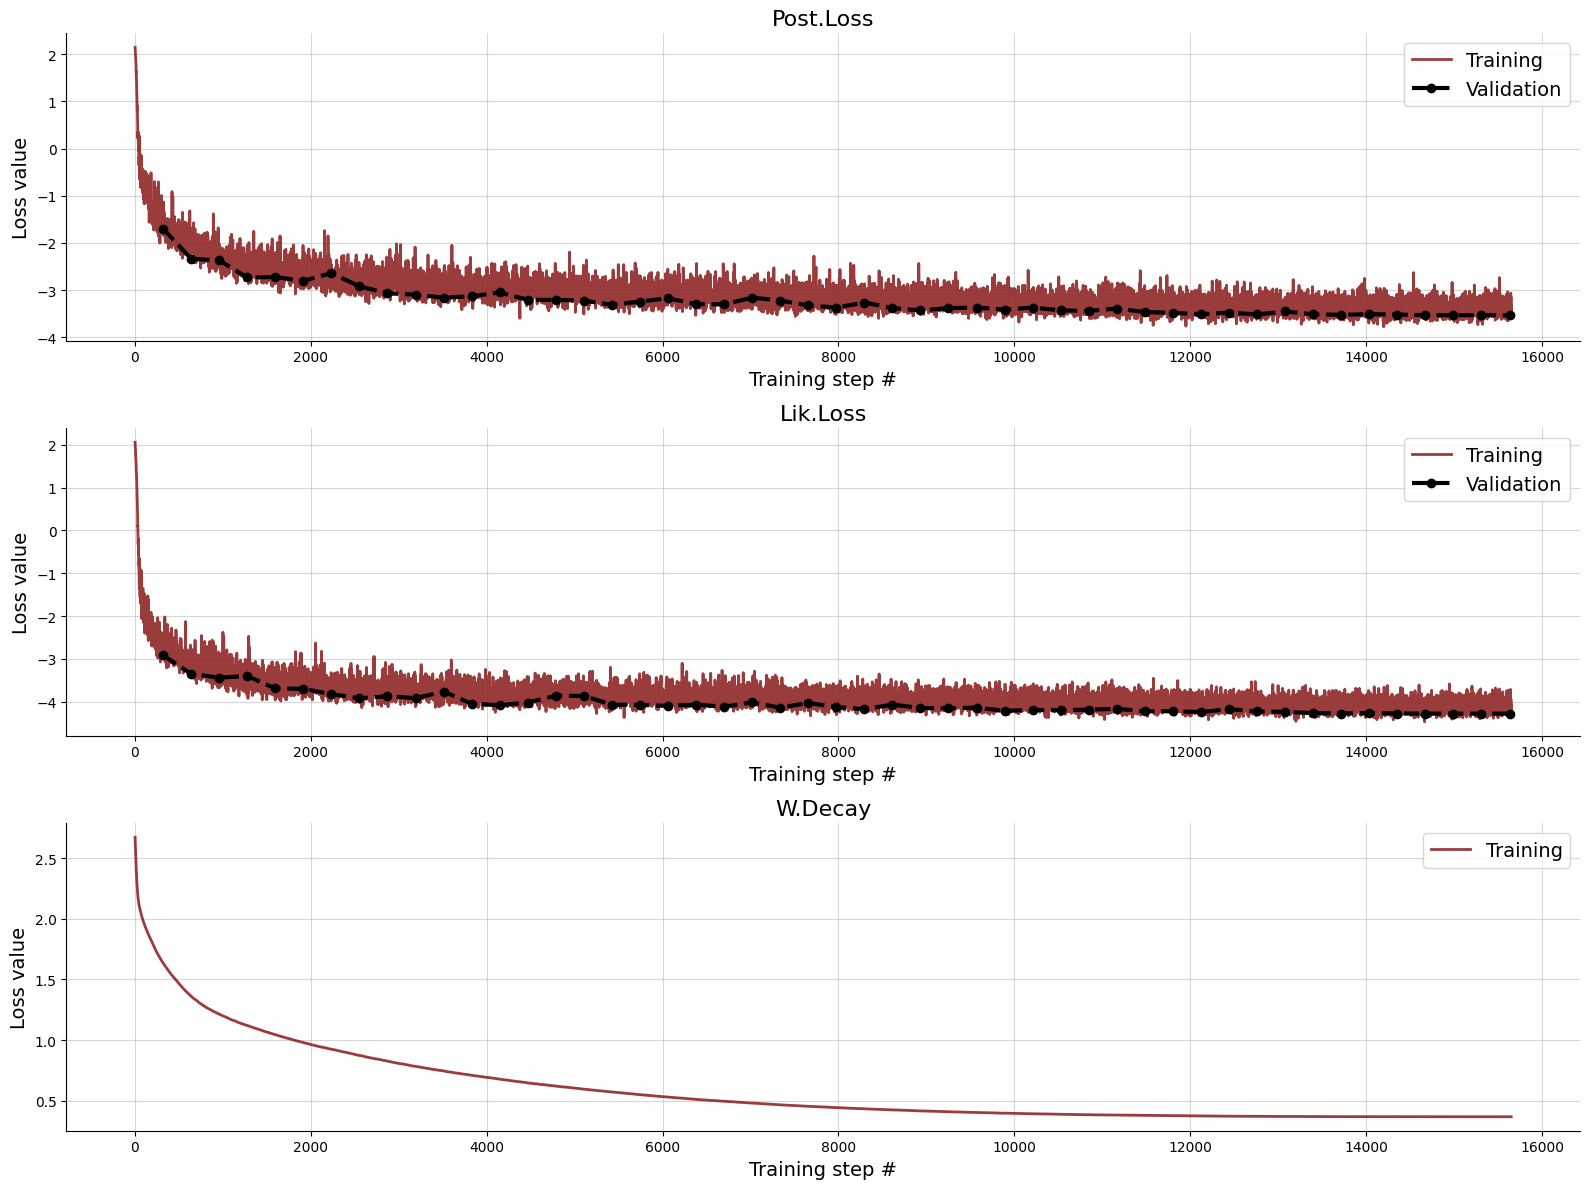

In [9]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

## Test Canonical Posterior

In [10]:
samples = amortizer.sample_parameters({'direct_conditions': np.zeros((1, 2), dtype=np.float32)}, 1000)

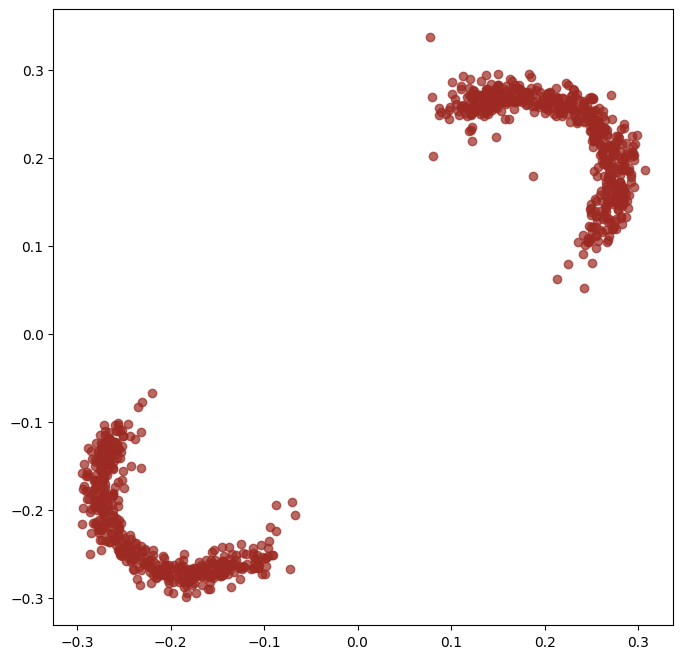

In [11]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(samples[:, 0], samples[:, 1], color='#9c2a22', alpha=0.7)

In [12]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [13]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'direct_conditions': x_sim_s}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

# Appendix Plots

In [14]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

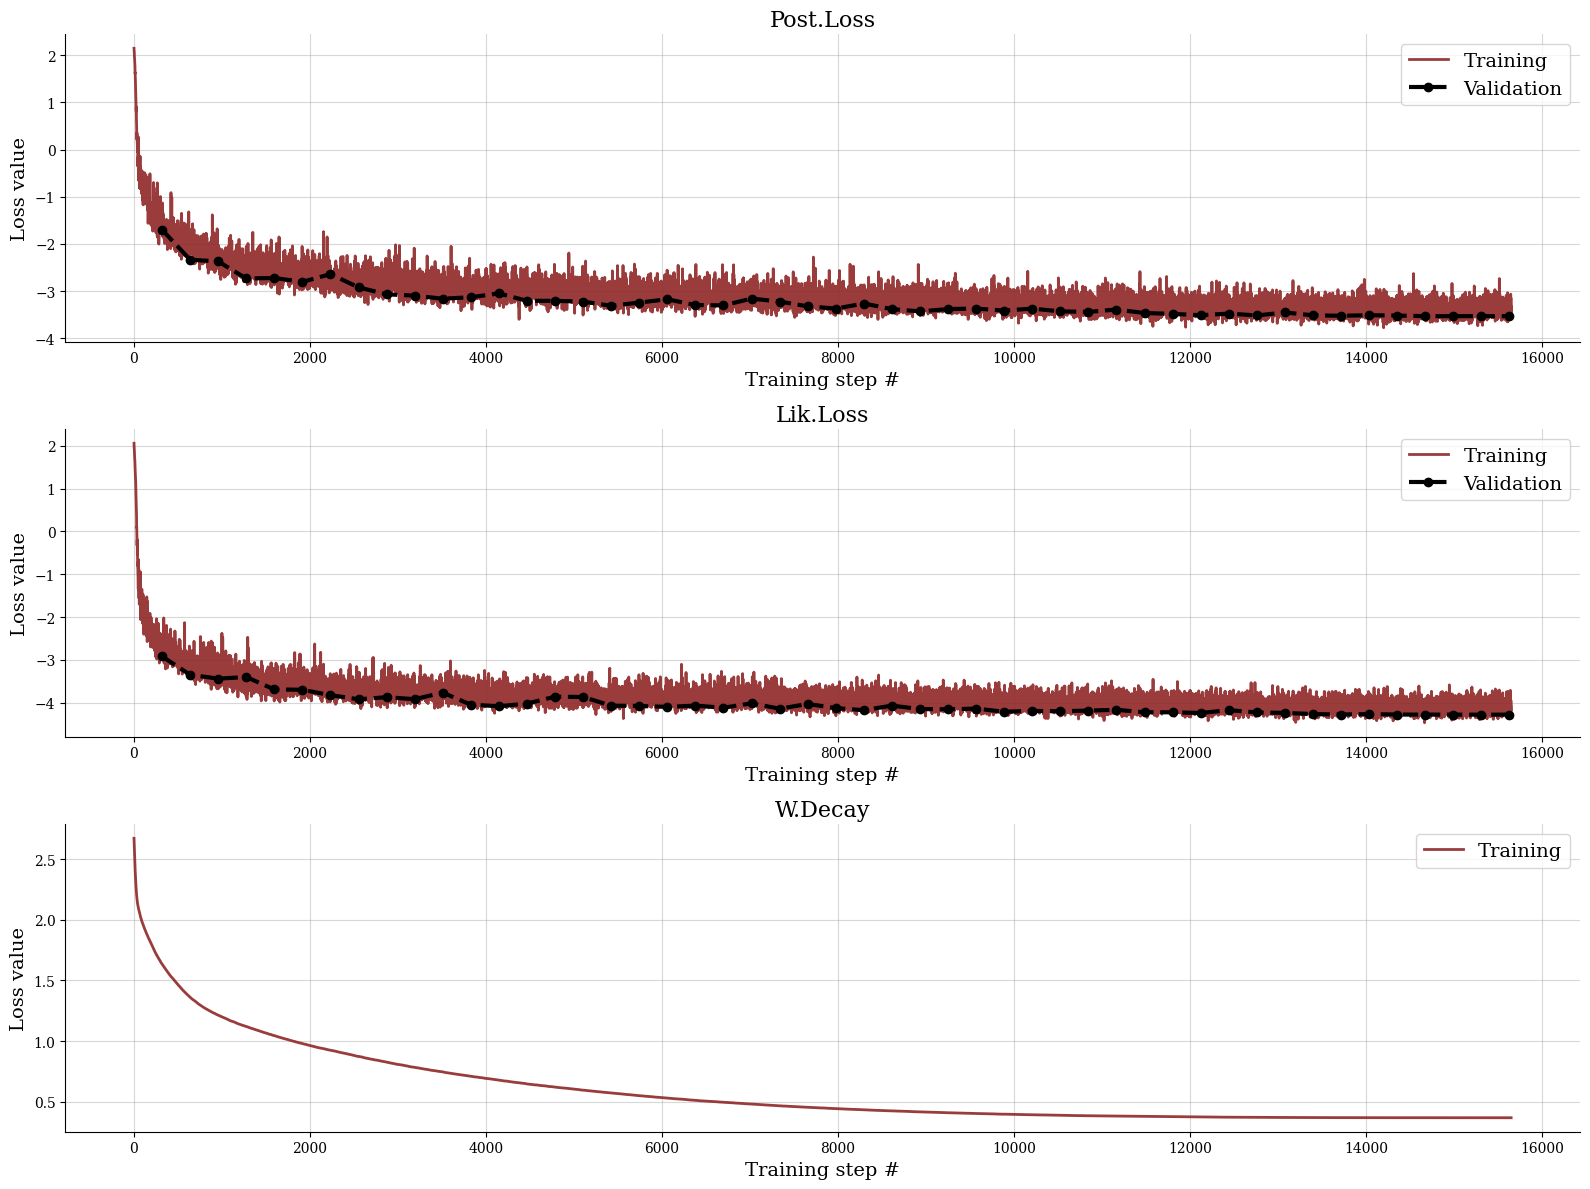

In [15]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

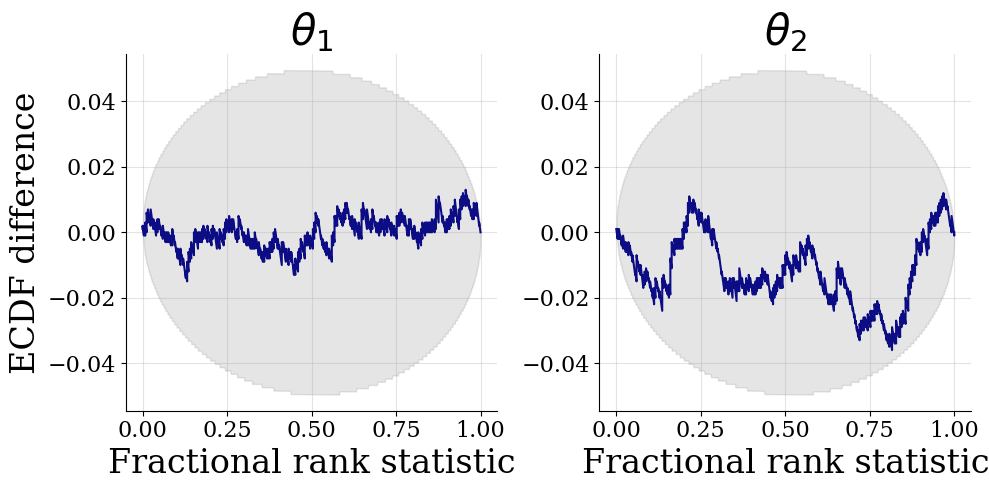

In [16]:
f = plot_sbc_ecdf_appendix(
    post_samples, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#000080'
)

plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")

### Joint Calibration

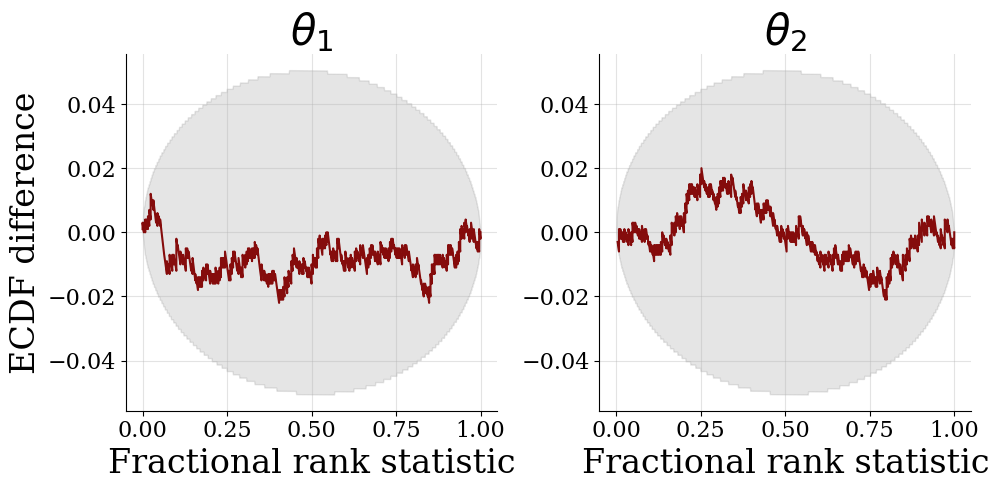

In [17]:
f = plot_sbc_ecdf_appendix(
    post_samples_s, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#800000'
)

plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")